# 0. Import bibliotek

In [1]:
from sklearn import datasets
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

parameters = {"figure.figsize": [15,5]}
plt.rcParams.update(parameters)

import xgboost as xgb
import lightgbm as lgb
import missingno as msno
import eli5
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score, learning_curve, KFold
from sklearn import metrics
from sklearn.metrics import mean_absolute_error
from scipy.stats import uniform, randint
from tqdm import tqdm

# 1. Przygotowanie zbiorów

## 1.1. Przegląd datasetu treningowego

In [2]:
# Wczytujemy dane

df_train = pd.read_hdf("train_data.v2.h5")
pd.set_option("display.max_columns", 150)

In [3]:
df_train.shape

(22732, 9)

Mamy 22732 wiersze i 9 kolumn.

In [4]:
df_train.head()

,geo_block,breadcrumbs,owner,params,date,user_block,id,price,params_en
0,"[г. Москва, Лианозово, г. Москва, Лианозово]","[Москва, Лианозово, м. Алтуфьево, МЦК Лихоборы]",[],"{'Охрана:': 'закрытая территория', 'Тип здания...","[22 апреля, 12, (+1 за сегодня), Обновлено 18 ...","[<div class=""block-user__name"">НДВ Недвижимост...",34995,5 402 084 ₽,"{'Security:': 'closed area', 'Building type:':..."
1,"[г. Москва, Ховрино, г. Москва, Ховрино]","[Москва, Ховрино, м. Ховрино, МЦК Коптево]",[],"{'Лифт:': 'да', 'Тип здания:': 'Монолитное', '...","[10 мая, 2, (+1 за сегодня), Обновлено 16 мая]","[<div class=""block-user__name"">MR-Group</div>,...",15030,6 827 990 ₽,"{'Elevator:': 'yes', 'Building type:': 'Monoli..."
2,"[г. Москва, ул Лобачевского, г. Москва, ул Лоб...","[Москва, МЦК Кутузовская, ул. Лобачевского]","[ЖК ""Крылья"". Доп. скидка 5%!]","{'Лифт:': 'да', 'Охрана:': 'закрытая территори...","[20 марта, 12, (+2 за сегодня), Обновлено 18 мая]",[],37811,8 680 000 ₽,"{'Elevator:': 'yes', 'Security:': 'closed area..."
3,"[г. Москва, Ховрино, ул Дыбенко, г. Москва, Хо...","[Москва, Ховрино, м. Ховрино, МЦК Коптево, ул....",[],"{'Лифт:': 'да', 'Тип здания:': 'Монолитное', '...","[29 апреля, 3, (+1 за сегодня), Обновлено 13 мая]","[<div class=""block-user__name"">MR-Group</div>,...",31685,8 624 435 ₽,"{'Elevator:': 'yes', 'Building type:': 'Monoli..."
4,"[г. Москва, Даниловский, г. Москва, Даниловский]","[Москва, Даниловский, м. Автозаводская, МЦК Ав...",[],"{'Общая площадь:': '141.1 м²', 'Дата публикаци...","[15 декабря 2018, 30, (+1 за сегодня), Обновле...","[<div class=""block-user__name"">Наталья Вдовиче...",56215,29 500 000 ₽,"{'Total area:': '141.1 м²', 'Date published:':..."


Targetem jest kolumna `price` i jest typu ciągłego.

Sprawdzamy ile jest pustych wartości w kolumnach.

In [5]:
df_train.isnull().sum().sort_values()

geo_block      0
breadcrumbs    0
owner          0
params         0
date           0
user_block     0
id             0
price          0
params_en      0
dtype: int64

Nie mamy pustych wartości

In [6]:
df_train.dtypes

geo_block      object
breadcrumbs    object
owner          object
params         object
date           object
user_block     object
id              int64
price          object
params_en      object
dtype: object

Wszystkie kolumny oprócz `id` są typu tekstowego

## 1.2. Przegląd datasetu testowego

In [7]:
# Wczytujemy dane

df_test = pd.read_hdf("test_data.v2.h5")

In [8]:
df_test.shape

(11448, 9)

Mamy 11448 wiersze i 9 kolumn.

In [9]:
df_test.head()

,geo_block,breadcrumbs,owner,params,date,user_block,id,price,params_en
0,"[г. Москва, Орехово-Борисово Южное, г. Москва,...","[Москва, Орехово-Борисово Южное, м. Домодедовс...",[],"{'Тип здания:': 'Монолитное', 'Тип объекта:': ...","[30 апреля 2018, 59, (+1 за сегодня), Обновлен...","[<div class=""block-user__name"">Группа ПИК</div...",24242,NaN,"{'Building type:': 'Monolithic', 'Object type:..."
1,"[г. Москва, ул Дыбенко, г. Москва, ул Дыбенко]","[Москва, МЦК Коптево, ул. Дыбенко]",[],"{'Тип здания:': 'Монолитный', 'Тип объекта:': ...","[23 апреля, 4, (+1 за сегодня), Обновлено 15 мая]","[<div class=""block-user__name"">Discovery</div>...",67622,NaN,"{'Building type:': 'Monolithic', 'Object type:..."
2,"[г. Москва, г. Москва]","[Москва, МЦК Хорошёво]",[],"{'Лифт:': 'да', 'Охрана:': 'предусмотрена', 'Т...","[11 мая, 3, (+2 за сегодня), Обновлено 17 мая]","[<div class=""block-user__name"">Галс-Девелопмен...",48993,NaN,"{'Elevator:': 'yes', 'Security:': 'provided', ..."
3,"[г. Москва, Хорошёво-Мнёвники, г. Москва, Хоро...","[Москва, Хорошёво-Мнёвники, м. Октябрьское пол...",[],"{'Лифт:': 'да', 'Охрана:': 'предусмотрена', 'Т...","[13 мая, 3, (+1 за сегодня)]","[<div class=""block-user__name"">Офис продаж ЖК ...",31394,NaN,"{'Elevator:': 'yes', 'Security:': 'provided', ..."
4,"[г. Москва, г. Москва]","[Москва, МЦК Ботанический сад]",[],"{'Лифт:': 'да', 'Охрана:': 'да', 'Тип здания:'...","[21 апреля, 10, (+2 за сегодня), Обновлено 17 ...","[<div class=""block-user__name"">Агент</div>, <d...",49832,NaN,"{'Elevator:': 'yes', 'Security:': 'Yes', 'Buil..."


Sprawdzamy ile jest pustych wartości w kolumnach.

In [10]:
df_test.isnull().sum().sort_values()

geo_block          0
breadcrumbs        0
owner              0
params             0
date               0
user_block         0
id                 0
params_en          0
price          11448
dtype: int64

Tutaj nie mamy cen

In [11]:
df_test.dtypes

geo_block      object
breadcrumbs    object
owner          object
params         object
date           object
user_block     object
id              int64
price          object
params_en      object
dtype: object

Wszystkie kolumny oprócz `id` są typu tekstowego

## 1.3. Przygotowanie danych

### 1.3.1. Target

Zobaczmy jak wygląda nasza zmienna docelowa.

In [12]:
df_train["price"]

0          5 402 084 ₽
1          6 827 990 ₽
2          8 680 000 ₽
3          8 624 435 ₽
4         29 500 000 ₽
             ...      
22727     12 650 000 ₽
22728     17 610 000 ₽
22729     14 941 300 ₽
22730     21 610 000 ₽
22731    110 000 000 ₽
Name: price, Length: 22732, dtype: object

Musimy ją przekonwertować na liczby. W tym celu usuniemy `₽` i spacje. Podzielimy ją też na `1000000` dla przejrzystości

In [13]:
df_train["price"] = df_train["price"].map(lambda x: int(x.split("₽")[0].replace(" ", ""))) / 1000000
df_train["price"]

0          5.402084
1          6.827990
2          8.680000
3          8.624435
4         29.500000
            ...    
22727     12.650000
22728     17.610000
22729     14.941300
22730     21.610000
22731    110.000000
Name: price, Length: 22732, dtype: float64

Zobaczmy jak przedstawia się nasz target na wykresach

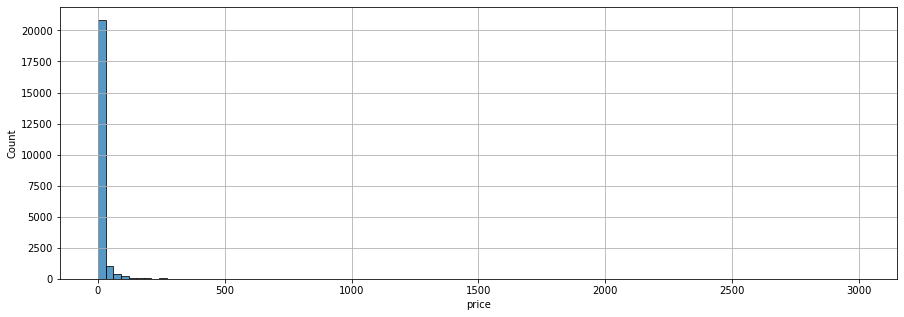

In [14]:
sns.histplot(x = df_train["price"], bins = 100)
plt.grid()

Bardzo dużo wartości skupionych i bardzo długi ogon.

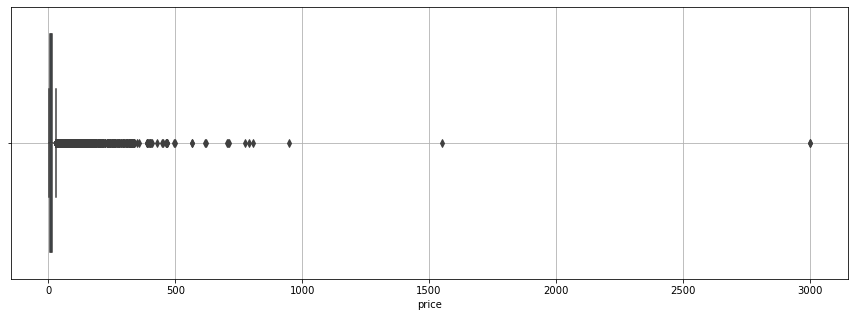

In [15]:
sns.boxplot(x = df_train["price"], data = df_train)
plt.grid()

In [16]:
df_train["price"].describe()

count    22732.000000
mean        17.525508
std         44.079082
min          1.040000
25%          7.162347
50%          9.888750
75%         15.410000
max       3000.000015
Name: price, dtype: float64

Aby poprawić wartości z targetu, zlogarytmizujemy je, by ich rozkład przypominał rozkład normalny.

In [17]:
df_train.loc[:, "price_log"] = np.log(df_train["price"])

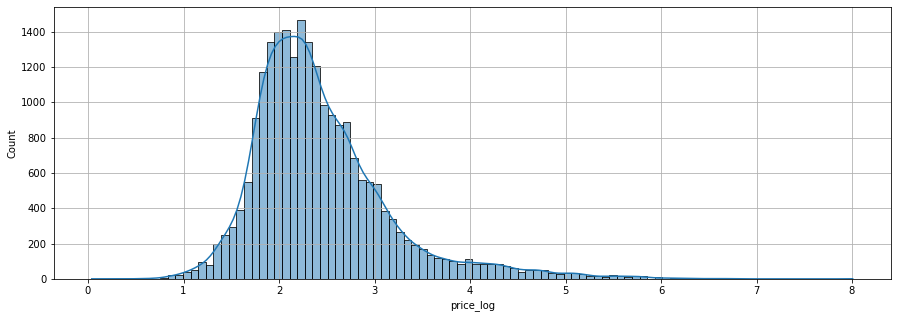

In [18]:
sns.histplot(x = df_train["price_log"], bins = 100, kde = True)
plt.grid()

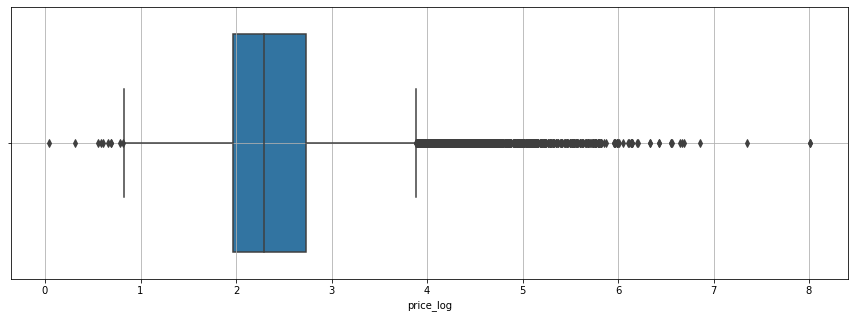

In [19]:
sns.boxplot(x = df_train["price_log"], data = df_train)
plt.grid()

In [20]:
df_train["price_log"].describe()

count    22732.000000
mean         2.437824
std          0.726566
min          0.039221
25%          1.968838
50%          2.291398
75%          2.735017
max          8.006368
Name: price_log, dtype: float64

Usuwamy outliery

In [21]:
"""q1 = df_train["price_log"].quantile(0.25)
q3 = df_train["price_log"].quantile(0.75)
iqr = q3 - q1
low = q1 - 1.5 * iqr
high = q3 + 1.5 * iqr

df_train = df_train[(df_train["price_log"] > low) & (df_train["price_log"] < high)]"""

'q1 = df_train["price_log"].quantile(0.25)\nq3 = df_train["price_log"].quantile(0.75)\niqr = q3 - q1\nlow = q1 - 1.5 * iqr\nhigh = q3 + 1.5 * iqr\n\ndf_train = df_train[(df_train["price_log"] > low) & (df_train["price_log"] < high)]'

In [22]:
"""sns.histplot(x = df_train["price_log"], kde = True)
plt.grid()"""

'sns.histplot(x = df_train["price_log"], kde = True)\nplt.grid()'

### 1.3.2. Przygotowanie zmiennych objaśniających

In [23]:
df = pd.concat([df_train, df_test])
df.head()

,geo_block,breadcrumbs,owner,params,date,user_block,id,price,params_en,price_log
0,"[г. Москва, Лианозово, г. Москва, Лианозово]","[Москва, Лианозово, м. Алтуфьево, МЦК Лихоборы]",[],"{'Охрана:': 'закрытая территория', 'Тип здания...","[22 апреля, 12, (+1 за сегодня), Обновлено 18 ...","[<div class=""block-user__name"">НДВ Недвижимост...",34995,5.402084,"{'Security:': 'closed area', 'Building type:':...",1.686785
1,"[г. Москва, Ховрино, г. Москва, Ховрино]","[Москва, Ховрино, м. Ховрино, МЦК Коптево]",[],"{'Лифт:': 'да', 'Тип здания:': 'Монолитное', '...","[10 мая, 2, (+1 за сегодня), Обновлено 16 мая]","[<div class=""block-user__name"">MR-Group</div>,...",15030,6.82799,"{'Elevator:': 'yes', 'Building type:': 'Monoli...",1.921030
2,"[г. Москва, ул Лобачевского, г. Москва, ул Лоб...","[Москва, МЦК Кутузовская, ул. Лобачевского]","[ЖК ""Крылья"". Доп. скидка 5%!]","{'Лифт:': 'да', 'Охрана:': 'закрытая территори...","[20 марта, 12, (+2 за сегодня), Обновлено 18 мая]",[],37811,8.68,"{'Elevator:': 'yes', 'Security:': 'closed area...",2.161022
3,"[г. Москва, Ховрино, ул Дыбенко, г. Москва, Хо...","[Москва, Ховрино, м. Ховрино, МЦК Коптево, ул....",[],"{'Лифт:': 'да', 'Тип здания:': 'Монолитное', '...","[29 апреля, 3, (+1 за сегодня), Обновлено 13 мая]","[<div class=""block-user__name"">MR-Group</div>,...",31685,8.624435,"{'Elevator:': 'yes', 'Building type:': 'Monoli...",2.154599
4,"[г. Москва, Даниловский, г. Москва, Даниловский]","[Москва, Даниловский, м. Автозаводская, МЦК Ав...",[],"{'Общая площадь:': '141.1 м²', 'Дата публикаци...","[15 декабря 2018, 30, (+1 за сегодня), Обновле...","[<div class=""block-user__name"">Наталья Вдовиче...",56215,29.5,"{'Total area:': '141.1 м²', 'Date published:':...",3.384390


Zmienne objaśniające znajdują się w kolumnie `params`. Wyciągnijmy je i puste wartości zamienimy na `-1`

In [24]:
params = df["params_en"].apply(pd.Series)
params = params.fillna(-1)

if "Охрана:" not in df:
    df = pd.concat([df, params], axis = 1)

In [25]:
df.head()

,geo_block,breadcrumbs,owner,params,date,user_block,id,price,params_en,price_log,Security:,Building type:,Object type:,Number of buildings:,Ad type:,Developer:,Total area:,Date published:,Number of rooms:,Parking:,Updated date:,Number of floors:,Surrender:,Commission agent:,Ceiling height:,Floor:,Construction phase:,New building:,Number of apartments:,Housing class:,Address:,Elevator:,The view from the window:,Mortgage possible:,Year built:,Garbage chute:,Repair:,Kitchen area:,Living room:,Bathroom type:,Balcony type:,Kitchen furniture:,Fridge:,Internet:,Furniture:,Phone:,Free layout:,Management company:,Number of entrances:,Type of the building:,Room type:,Floor covering:,Series:,Overlap type:,It is possible to bargain:,Class:,TV:,Foundation type:,Number of dwellings:,Playground:,Washing machine:,The largest number of floors:,The smallest number of floors:,Pre-pay
0,"[г. Москва, Лианозово, г. Москва, Лианозово]","[Москва, Лианозово, м. Алтуфьево, МЦК Лихоборы]",[],"{'Охрана:': 'закрытая территория', 'Тип здания...","[22 апреля, 12, (+1 за сегодня), Обновлено 18 ...","[<div class=""block-user__name"">НДВ Недвижимост...",34995,5.402084,"{'Security:': 'closed area', 'Building type:':...",1.686785,closed area,Monolithic,apartments,1,new building,Доходный дом,54.3 м²,22 апреля,2,"отдельная многоуровневая, гостевая",18 мая,11,1 кв. 2020 года,no fee,2.8 м,8/11,Building walls,"Апарт-комплекс Nord, м. Алтуфьево",163,Comfort class,,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
1,"[г. Москва, Ховрино, г. Москва, Ховрино]","[Москва, Ховрино, м. Ховрино, МЦК Коптево]",[],"{'Лифт:': 'да', 'Тип здания:': 'Монолитное', '...","[10 мая, 2, (+1 за сегодня), Обновлено 16 мая]","[<div class=""block-user__name"">MR-Group</div>,...",15030,6.82799,"{'Elevator:': 'yes', 'Building type:': 'Monoli...",1.921030,-1,Monolithic,flat,5,new building,MR Group,38 м²,10 мая,2,подземная,16 мая,31,2 кв. 2021 года,no fee,3.15 м,6/31,Building walls,"ЖК Discovery (ЖК «Дискавери»), м. Ховрино",1251,Comfort class,,yes,street,yes,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
2,"[г. Москва, ул Лобачевского, г. Москва, ул Лоб...","[Москва, МЦК Кутузовская, ул. Лобачевского]","[ЖК ""Крылья"". Доп. скидка 5%!]","{'Лифт:': 'да', 'Охрана:': 'закрытая территори...","[20 марта, 12, (+2 за сегодня), Обновлено 18 мая]",[],37811,8.68,"{'Elevator:': 'yes', 'Security:': 'closed area...",2.161022,closed area,Monolithic,apartments,3,from the developer,АО «Лидер Инвест»,40 м²,20 марта,1,"подземная на 1103 м/м, открытая",18 мая,от 21 до 39,-1,no fee,3 м,20,Playground,"ЖК «Крылья», м. Раменки",1473,Business class,,yes,-1,-1,2021,yes,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
3,"[г. Москва, Ховрино, ул Дыбенко, г. Москва, Хо...","[Москва, Ховрино, м. Ховрино, МЦК Коптево, ул....",[],"{'Лифт:': 'да', 'Тип здания:': 'Монолитное', '...","[29 апреля, 3, (+1 за сегодня), Обновлено 13 мая]","[<div class=""block-user__name"">MR-Group</div>,...",31685,8.624435,"{'Elevator:': 'yes', 'Building type:': 'Monoli...",2.154599,-1,Monolithic,flat,5,new building,MR Group,43 м²,29 апреля,2,подземная,13 мая,31,2 кв. 2021 года,no fee,3.15 м,27/31,Building walls,"ЖК Discovery (ЖК «Дискавери»), м. Ховрино",1251,Comfort class,,yes,street,yes,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
4,"[г. Москва, Даниловский, г. Москва, Даниловский]","[Москва, Даниловский, м. Автозаводская, МЦК Ав...",[],"{'Общая площадь:': '141.1 м²', 'Дата публикаци...","[15 декабря 2018, 30, (+1 за сегодня), Обновле...","[<div class=""block-user__name"">Наталья Вдовиче...",56215,29.5,"{'Total area:': '141.1 м²', 'Date published:':...",3.384390,-1,Monolithic,apartments,-1,secondary,-1,141.1 м²,15 декабря 2018,4,-1,15 мая,16,-1,no fee,-1,2/16,-1,-1,-1,-1,"Москва, м. Автозаводская, Москва, проезд Павел...",-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,

Kolumny `Total area`, `Kitchen area`, `Ceiling height` i ` Living room` zamienimy na `float` usuwając litery.

In [26]:
def parse_area(val):
    if isinstance(val, int): 
        return val
    if isinstance(val, float): 
        return val
    
    return float(val.split("м")[0].replace(" ", ""))

df["Total area:"] = df["Total area:"].map(parse_area)
df["Kitchen area:"] = df["Kitchen area:"].map(parse_area)
df["Ceiling height:"] = df["Ceiling height:"].map(parse_area)
df["Living room:"] = df["Living room:"].map(parse_area)

Przyjrzyjmy się bliżej tym kolumnom.

In [27]:
"""df[["Total area:", "Kitchen area:", "Ceiling height:", "Living room:"]].describe()"""

'df[["Total area:", "Kitchen area:", "Ceiling height:", "Living room:"]].describe()'

Zlogarytmujemy kolumnę `Total area`

In [28]:
"""df["log_Total area:"] = np.log(df["Total area:"])"""

'df["log_Total area:"] = np.log(df["Total area:"])'

Zmiana typów kolumn na `int`

In [29]:
def get_number(val):
    if isinstance(val, int): 
        return val
    if isinstance(val, float): 
        return val
    
    if "от" in val:
        return int(val.split(" ")[3]) - int(val.split(" ")[1])
    else:
        return int(val)

In [30]:
df["Year built:"] = df["Year built:"].astype(int)
df["Number of apartments:"] = df["Number of apartments:"].astype(int)
df["Number of floors:"] = df["Number of floors:"].map(get_number)
df["Number of rooms:"] = df["Number of rooms:"].astype(int)
df["Number of buildings:"] = df["Number of buildings:"].astype(int)
df["Number of entrances:"] = df["Number of entrances:"].astype(int)
df["Number of dwellings:"] = df["Number of dwellings:"].astype(int)
df["The largest number of floors:"] = df["The largest number of floors:"].astype(int)
df["The smallest number of floors:"] = df["The smallest number of floors:"].astype(int)

In [31]:
df.head()

,geo_block,breadcrumbs,owner,params,date,user_block,id,price,params_en,price_log,Security:,Building type:,Object type:,Number of buildings:,Ad type:,Developer:,Total area:,Date published:,Number of rooms:,Parking:,Updated date:,Number of floors:,Surrender:,Commission agent:,Ceiling height:,Floor:,Construction phase:,New building:,Number of apartments:,Housing class:,Address:,Elevator:,The view from the window:,Mortgage possible:,Year built:,Garbage chute:,Repair:,Kitchen area:,Living room:,Bathroom type:,Balcony type:,Kitchen furniture:,Fridge:,Internet:,Furniture:,Phone:,Free layout:,Management company:,Number of entrances:,Type of the building:,Room type:,Floor covering:,Series:,Overlap type:,It is possible to bargain:,Class:,TV:,Foundation type:,Number of dwellings:,Playground:,Washing machine:,The largest number of floors:,The smallest number of floors:,Pre-pay
0,"[г. Москва, Лианозово, г. Москва, Лианозово]","[Москва, Лианозово, м. Алтуфьево, МЦК Лихоборы]",[],"{'Охрана:': 'закрытая территория', 'Тип здания...","[22 апреля, 12, (+1 за сегодня), Обновлено 18 ...","[<div class=""block-user__name"">НДВ Недвижимост...",34995,5.402084,"{'Security:': 'closed area', 'Building type:':...",1.686785,closed area,Monolithic,apartments,1,new building,Доходный дом,54.3,22 апреля,2,"отдельная многоуровневая, гостевая",18 мая,11,1 кв. 2020 года,no fee,2.80,8/11,Building walls,"Апарт-комплекс Nord, м. Алтуфьево",163,Comfort class,,-1,-1,-1,-1,-1,-1,-1.0,-1.0,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
1,"[г. Москва, Ховрино, г. Москва, Ховрино]","[Москва, Ховрино, м. Ховрино, МЦК Коптево]",[],"{'Лифт:': 'да', 'Тип здания:': 'Монолитное', '...","[10 мая, 2, (+1 за сегодня), Обновлено 16 мая]","[<div class=""block-user__name"">MR-Group</div>,...",15030,6.82799,"{'Elevator:': 'yes', 'Building type:': 'Monoli...",1.921030,-1,Monolithic,flat,5,new building,MR Group,38.0,10 мая,2,подземная,16 мая,31,2 кв. 2021 года,no fee,3.15,6/31,Building walls,"ЖК Discovery (ЖК «Дискавери»), м. Ховрино",1251,Comfort class,,yes,street,yes,-1,-1,-1,-1.0,-1.0,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
2,"[г. Москва, ул Лобачевского, г. Москва, ул Лоб...","[Москва, МЦК Кутузовская, ул. Лобачевского]","[ЖК ""Крылья"". Доп. скидка 5%!]","{'Лифт:': 'да', 'Охрана:': 'закрытая территори...","[20 марта, 12, (+2 за сегодня), Обновлено 18 мая]",[],37811,8.68,"{'Elevator:': 'yes', 'Security:': 'closed area...",2.161022,closed area,Monolithic,apartments,3,from the developer,АО «Лидер Инвест»,40.0,20 марта,1,"подземная на 1103 м/м, открытая",18 мая,18,-1,no fee,3.00,20,Playground,"ЖК «Крылья», м. Раменки",1473,Business class,,yes,-1,-1,2021,yes,-1,-1.0,-1.0,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
3,"[г. Москва, Ховрино, ул Дыбенко, г. Москва, Хо...","[Москва, Ховрино, м. Ховрино, МЦК Коптево, ул....",[],"{'Лифт:': 'да', 'Тип здания:': 'Монолитное', '...","[29 апреля, 3, (+1 за сегодня), Обновлено 13 мая]","[<div class=""block-user__name"">MR-Group</div>,...",31685,8.624435,"{'Elevator:': 'yes', 'Building type:': 'Monoli...",2.154599,-1,Monolithic,flat,5,new building,MR Group,43.0,29 апреля,2,подземная,13 мая,31,2 кв. 2021 года,no fee,3.15,27/31,Building walls,"ЖК Discovery (ЖК «Дискавери»), м. Ховрино",1251,Comfort class,,yes,street,yes,-1,-1,-1,-1.0,-1.0,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
4,"[г. Москва, Даниловский, г. Москва, Даниловский]","[Москва, Даниловский, м. Автозаводская, МЦК Ав...",[],"{'Общая площадь:': '141.1 м²', 'Дата публикаци...","[15 декабря 2018, 30, (+1 за сегодня), Обновле...","[<div class=""block-user__name"">Наталья Вдовиче...",56215,29.5,"{'Total area:': '141.1 м²', 'Date published:':...",3.384390,-1,Monolithic,apartments,-1,secondary,-1,141.1,15 декабря 2018,4,-1,15 мая,16,-1,no fee,-1.00,2/16,-1,-1,-1,-1,"Москва, м. Автозаводская, Москва, проезд Павел...",-1,-1,-1,-1,-1,-1,-1.0,-1.0,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1

### 1.3.3. Future Engineering

Przeanalizujmy kolumnę `geo_block`

In [32]:
df["geo_block"].values

array([list(['г. Москва', 'Лианозово', 'г. Москва', 'Лианозово']),
       list(['г. Москва', 'Ховрино', 'г. Москва', 'Ховрино']),
       list(['г. Москва', 'ул Лобачевского', 'г. Москва', 'ул Лобачевского']),
       ..., list(['г. Москва', 'Ховрино', 'г. Москва', 'Ховрино']),
       list(['Новая Москва', 'п. Внуковское', 'г. Москва', 'Новая Москва', 'п. Внуковское', 'г. Москва']),
       list(['г. Москва', 'Ярославский', 'ул Красная Сосна', 'г. Москва', 'Ярославский', 'ул Красная Сосна'])],
      dtype=object)

In [33]:
geo_block = (df["geo_block"]
    .map(lambda x: x[:int(len(x)/2)])
    .map(lambda x: {f"geo_block_{idx}": val for idx, val in enumerate(x)})
    .apply(pd.Series))

geo_block

,geo_block_0,geo_block_1,geo_block_2,geo_block_3,geo_block_4,geo_block_5
0,г. Москва,Лианозово,NaN,NaN,NaN,NaN
1,г. Москва,Ховрино,NaN,NaN,NaN,NaN
2,г. Москва,ул Лобачевского,NaN,NaN,NaN,NaN
3,г. Москва,Ховрино,ул Дыбенко,NaN,NaN,NaN
4,г. Москва,Даниловский,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
11443,г. Москва,NaN,NaN,NaN,NaN,NaN
11444,г. Москва,Хорошёво-Мнёвники,NaN,NaN,NaN,NaN
11445,г. Москва,Ховрино,NaN,NaN,NaN,NaN
11446,Новая Москва,п. Внуковское,г. Москва,NaN,NaN,NaN


In [34]:
for feat in geo_block.columns:
    df[f"{feat}_cat"] = geo_block[feat].factorize()[0]

In [35]:
geo_cat_feats = [x for x in df.columns if "geo_block" in x and "_cat" in x]
geo_cat_feats

['geo_block_0_cat',
 'geo_block_1_cat',
 'geo_block_2_cat',
 'geo_block_3_cat',
 'geo_block_4_cat',
 'geo_block_5_cat']

Analogicznie robimy z kolumną `breadcrumbs`

In [36]:
df["breadcrumbs"].values

array([list(['Москва', 'Лианозово', 'м. Алтуфьево', 'МЦК Лихоборы']),
       list(['Москва', 'Ховрино', 'м. Ховрино', 'МЦК Коптево']),
       list(['Москва', 'МЦК Кутузовская', 'ул. Лобачевского']), ...,
       list(['Москва', 'Ховрино', 'м. Ховрино', 'МЦК Коптево']),
       list(['Москва', 'Новая Москва', 'п. Внуковское', 'МЦК Кутузовская']),
       list(['Москва', 'Ярославский', 'МЦК Ростокино', 'ул. Красная Сосна'])],
      dtype=object)

In [37]:
breadcrumbs = (df["breadcrumbs"]
        .map(lambda x: {f"breadcrumbs_{idx}": val for idx, val in enumerate(x)})
        .apply(pd.Series))

breadcrumbs

,breadcrumbs_0,breadcrumbs_1,breadcrumbs_2,breadcrumbs_3,breadcrumbs_4,breadcrumbs_5,breadcrumbs_6,breadcrumbs_7
0,Москва,Лианозово,м. Алтуфьево,МЦК Лихоборы,NaN,NaN,NaN,NaN
1,Москва,Ховрино,м. Ховрино,МЦК Коптево,NaN,NaN,NaN,NaN
2,Москва,МЦК Кутузовская,ул. Лобачевского,NaN,NaN,NaN,NaN,NaN
3,Москва,Ховрино,м. Ховрино,МЦК Коптево,ул. Дыбенко,NaN,NaN,NaN
4,Москва,Даниловский,м. Автозаводская,МЦК Автозаводская,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
11443,Москва,МЦК Кутузовская,NaN,NaN,NaN,NaN,NaN,NaN
11444,Москва,Хорошёво-Мнёвники,м. Октябрьское поле,МЦК Зорге,NaN,NaN,NaN,NaN
11445,Москва,Ховрино,м. Ховрино,МЦК Коптево,NaN,NaN,NaN,NaN
11446,Москва,Новая Москва,п. Внуковское,МЦК Кутузовская,NaN,NaN,NaN,NaN


In [38]:
for feat in breadcrumbs.columns:
    df[f"{feat}_cat"] = breadcrumbs[feat].factorize()[0]

In [39]:
breadcrumbs_cat_feats = [x for x in df.columns if "breadcrumbs" in x and "_cat" in x]
breadcrumbs_cat_feats

['breadcrumbs_0_cat',
 'breadcrumbs_1_cat',
 'breadcrumbs_2_cat',
 'breadcrumbs_3_cat',
 'breadcrumbs_4_cat',
 'breadcrumbs_5_cat',
 'breadcrumbs_6_cat',
 'breadcrumbs_7_cat']

`Floor:`

In [40]:
df["Floor:"] = df["Floor:"].map(lambda x: int(str(x).split("/")[0].replace(" ", "")))

In [41]:
df.head()

,geo_block,breadcrumbs,owner,params,date,user_block,id,price,params_en,price_log,Security:,Building type:,Object type:,Number of buildings:,Ad type:,Developer:,Total area:,Date published:,Number of rooms:,Parking:,Updated date:,Number of floors:,Surrender:,Commission agent:,Ceiling height:,Floor:,Construction phase:,New building:,Number of apartments:,Housing class:,Address:,Elevator:,The view from the window:,Mortgage possible:,Year built:,Garbage chute:,Repair:,Kitchen area:,Living room:,Bathroom type:,Balcony type:,Kitchen furniture:,Fridge:,Internet:,Furniture:,Phone:,Free layout:,Management company:,Number of entrances:,Type of the building:,Room type:,Floor covering:,Series:,Overlap type:,It is possible to bargain:,Class:,TV:,Foundation type:,Number of dwellings:,Playground:,Washing machine:,The largest number of floors:,The smallest number of floors:,Pre-pay,geo_block_0_cat,geo_block_1_cat,geo_block_2_cat,geo_block_3_cat,geo_block_4_cat,geo_block_5_cat,breadcrumbs_0_cat,breadcrumbs_1_cat,breadcrumbs_2_cat,breadcrumbs_3_cat,breadcrumbs_4_cat,breadcrumbs_5_cat,breadcrumbs_6_cat,breadcrumbs_7_cat
0,"[г. Москва, Лианозово, г. Москва, Лианозово]","[Москва, Лианозово, м. Алтуфьево, МЦК Лихоборы]",[],"{'Охрана:': 'закрытая территория', 'Тип здания...","[22 апреля, 12, (+1 за сегодня), Обновлено 18 ...","[<div class=""block-user__name"">НДВ Недвижимост...",34995,5.402084,"{'Security:': 'closed area', 'Building type:':...",1.686785,closed area,Monolithic,apartments,1,new building,Доходный дом,54.3,22 апреля,2,"отдельная многоуровневая, гостевая",18 мая,11,1 кв. 2020 года,no fee,2.80,8,Building walls,"Апарт-комплекс Nord, м. Алтуфьево",163,Comfort class,,-1,-1,-1,-1,-1,-1,-1.0,-1.0,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,0,0,-1,-1,-1,-1,0,0,0,0,-1,-1,-1,-1
1,"[г. Москва, Ховрино, г. Москва, Ховрино]","[Москва, Ховрино, м. Ховрино, МЦК Коптево]",[],"{'Лифт:': 'да', 'Тип здания:': 'Монолитное', '...","[10 мая, 2, (+1 за сегодня), Обновлено 16 мая]","[<div class=""block-user__name"">MR-Group</div>,...",15030,6.82799,"{'Elevator:': 'yes', 'Building type:': 'Monoli...",1.921030,-1,Monolithic,flat,5,new building,MR Group,38.0,10 мая,2,подземная,16 мая,31,2 кв. 2021 года,no fee,3.15,6,Building walls,"ЖК Discovery (ЖК «Дискавери»), м. Ховрино",1251,Comfort class,,yes,street,yes,-1,-1,-1,-1.0,-1.0,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,0,1,-1,-1,-1,-1,0,1,1,1,-1,-1,-1,-1
2,"[г. Москва, ул Лобачевского, г. Москва, ул Лоб...","[Москва, МЦК Кутузовская, ул. Лобачевского]","[ЖК ""Крылья"". Доп. скидка 5%!]","{'Лифт:': 'да', 'Охрана:': 'закрытая территори...","[20 марта, 12, (+2 за сегодня), Обновлено 18 мая]",[],37811,8.68,"{'Elevator:': 'yes', 'Security:': 'closed area...",2.161022,closed area,Monolithic,apartments,3,from the developer,АО «Лидер Инвест»,40.0,20 марта,1,"подземная на 1103 м/м, открытая",18 мая,18,-1,no fee,3.00,20,Playground,"ЖК «Крылья», м. Раменки",1473,Business class,,yes,-1,-1,2021,yes,-1,-1.0,-1.0,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,0,2,-1,-1,-1,-1,0,2,2,-1,-1,-1,-1,-1
3,"[г. Москва, Ховрино, ул Дыбенко, г. Москва, Хо...","[Москва, Ховрино, м. Ховрино, МЦК Коптево, ул....",[],"{'Лифт:': 'да', 'Тип здания:': 'Монолитное', '...","[29 апреля, 3, (+1 за сегодня), Обновлено 13 мая]","[<div class=""block-user__name"">MR-Group</div>,...",31685,8.624435,"{'Elevator:': 'yes', 'Building type:': 'Monoli...",2.154599,-1,Monolithic,flat,5,new building,MR Group,43.0,29 апреля,2,подземная,13 мая,31,2 кв. 2021 года,no fee,3.15,27,Building walls,"ЖК Discovery (ЖК «Дискавери»), м. Ховрино",1251,Comfort class,,yes,street,yes,-1,-1,-1,-1.0,-1.0,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,0,1,0,-1,-1,-1,0,1,1,1,0,-1,-1,-1
4,"[г. Москва, Даниловский, г. Москва, Даниловский]","[Москва, Даниловский, м. Автозаводская, МЦК Ав...",[],"{'Общая площадь:': '141.1 м²', 'Дата публикаци...","[15 декабря 2018, 30, (

`metro`

In [42]:
def get_metro_station(row):
    for i in row:
        if 'МЦК' in i:
            return i
    
metro_station = (df["breadcrumbs"].map(lambda x: get_metro_station(x)).apply(pd.Series))
metro_station

,0
0,МЦК Лихоборы
1,МЦК Коптево
2,МЦК Кутузовская
3,МЦК Коптево
4,МЦК Автозаводская
...,...
11443,МЦК Кутузовская
11444,МЦК Зорге
11445,МЦК Коптево
11446,МЦК Кутузовская


In [43]:
df["Metro_cat"] = metro_station.apply(lambda x: pd.factorize(x)[0])

`Date published:`, `Updated date:`

In [44]:
date_published = (df["Date published:"]
    .map(lambda x: str(x).split(" "))
    .map(lambda x: {f"Date_published_{idx}": val for idx, val in enumerate(x)})
    .apply(pd.Series))

for i in date_published.columns:
    df[f"{i}_cat"] = date_published[i].factorize()[0]

In [45]:
update_date = (df["Updated date:"]
    .map(lambda x: str(x).split(" "))
    .map(lambda x: {f"Updated date_{idx}": val for idx, val in enumerate(x)})
    .apply(pd.Series))

for i in update_date.columns:
    df[f"{i}_cat"] = update_date[i].factorize()[0]

In [46]:
df.head()

,geo_block,breadcrumbs,owner,params,date,user_block,id,price,params_en,price_log,Security:,Building type:,Object type:,Number of buildings:,Ad type:,Developer:,Total area:,Date published:,Number of rooms:,Parking:,Updated date:,Number of floors:,Surrender:,Commission agent:,Ceiling height:,Floor:,Construction phase:,New building:,Number of apartments:,Housing class:,Address:,Elevator:,The view from the window:,Mortgage possible:,Year built:,Garbage chute:,Repair:,Kitchen area:,Living room:,Bathroom type:,Balcony type:,Kitchen furniture:,Fridge:,Internet:,Furniture:,Phone:,Free layout:,Management company:,Number of entrances:,Type of the building:,Room type:,Floor covering:,Series:,Overlap type:,It is possible to bargain:,Class:,TV:,Foundation type:,Number of dwellings:,Playground:,Washing machine:,The largest number of floors:,The smallest number of floors:,Pre-pay,geo_block_0_cat,geo_block_1_cat,geo_block_2_cat,geo_block_3_cat,geo_block_4_cat,geo_block_5_cat,breadcrumbs_0_cat,breadcrumbs_1_cat,breadcrumbs_2_cat,breadcrumbs_3_cat,breadcrumbs_4_cat,breadcrumbs_5_cat,breadcrumbs_6_cat,breadcrumbs_7_cat,Metro_cat,Date_published_0_cat,Date_published_1_cat,Date_published_2_cat,Updated date_0_cat,Updated date_1_cat,Updated date_2_cat
0,"[г. Москва, Лианозово, г. Москва, Лианозово]","[Москва, Лианозово, м. Алтуфьево, МЦК Лихоборы]",[],"{'Охрана:': 'закрытая территория', 'Тип здания...","[22 апреля, 12, (+1 за сегодня), Обновлено 18 ...","[<div class=""block-user__name"">НДВ Недвижимост...",34995,5.402084,"{'Security:': 'closed area', 'Building type:':...",1.686785,closed area,Monolithic,apartments,1,new building,Доходный дом,54.3,22 апреля,2,"отдельная многоуровневая, гостевая",18 мая,11,1 кв. 2020 года,no fee,2.80,8,Building walls,"Апарт-комплекс Nord, м. Алтуфьево",163,Comfort class,,-1,-1,-1,-1,-1,-1,-1.0,-1.0,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,0,0,-1,-1,-1,-1,0,0,0,0,-1,-1,-1,-1,0,0,0,-1,0,0,-1
1,"[г. Москва, Ховрино, г. Москва, Ховрино]","[Москва, Ховрино, м. Ховрино, МЦК Коптево]",[],"{'Лифт:': 'да', 'Тип здания:': 'Монолитное', '...","[10 мая, 2, (+1 за сегодня), Обновлено 16 мая]","[<div class=""block-user__name"">MR-Group</div>,...",15030,6.82799,"{'Elevator:': 'yes', 'Building type:': 'Monoli...",1.921030,-1,Monolithic,flat,5,new building,MR Group,38.0,10 мая,2,подземная,16 мая,31,2 кв. 2021 года,no fee,3.15,6,Building walls,"ЖК Discovery (ЖК «Дискавери»), м. Ховрино",1251,Comfort class,,yes,street,yes,-1,-1,-1,-1.0,-1.0,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,0,1,-1,-1,-1,-1,0,1,1,1,-1,-1,-1,-1,1,1,1,-1,1,0,-1
2,"[г. Москва, ул Лобачевского, г. Москва, ул Лоб...","[Москва, МЦК Кутузовская, ул. Лобачевского]","[ЖК ""Крылья"". Доп. скидка 5%!]","{'Лифт:': 'да', 'Охрана:': 'закрытая территори...","[20 марта, 12, (+2 за сегодня), Обновлено 18 мая]",[],37811,8.68,"{'Elevator:': 'yes', 'Security:': 'closed area...",2.161022,closed area,Monolithic,apartments,3,from the developer,АО «Лидер Инвест»,40.0,20 марта,1,"подземная на 1103 м/м, открытая",18 мая,18,-1,no fee,3.00,20,Playground,"ЖК «Крылья», м. Раменки",1473,Business class,,yes,-1,-1,2021,yes,-1,-1.0,-1.0,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,0,2,-1,-1,-1,-1,0,2,2,-1,-1,-1,-1,-1,2,2,2,-1,0,0,-1
3,"[г. Москва, Ховрино, ул Дыбенко, г. Москва, Хо...","[Москва, Ховрино, м. Ховрино, МЦК Коптево, ул....",[],"{'Лифт:': 'да', 'Тип здания:': 'Монолитное', '...","[29 апреля, 3, (+1 за сегодня), Обновлено 13 мая]","[<div class=""block-user__name"">MR-Group</div>,...",31685,8.624435,"{'Elevator:': 'yes', 'Building type:': 'Monoli...",2.154599,-1,Monolithic,flat,5,new building,MR Group,43.0,29 апреля,2,подземная,13 мая,31,2 кв. 2021 года,no fee,3.15,27,Building walls,"ЖК Discovery (ЖК «Дискавери»), м. Ховрино",1251,Comfort class,,yes,street,yes,-1,-1,-1,-1.0,-1.0,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,0,1,0,-1,-1,-1,0,1,1,1,0,-1,-1,-1,1,3,0,

In [47]:
pd.set_option("display.min_rows", 500)
pd.set_option("display.max_rows", 500)
df.dtypes

geo_block                          object
breadcrumbs                        object
owner                              object
params                             object
date                               object
user_block                         object
id                                  int64
price                              object
params_en                          object
price_log                         float64
Security:                          object
Building type:                     object
Object type:                       object
Number of buildings:                int32
Ad type:                           object
Developer:                         object
Total area:                       float64
Date published:                    object
Number of rooms:                    int32
Parking:                           object
Updated date:                      object
Number of floors:                   int64
Surrender:                         object
Commission agent:                 

In [48]:
df = df.drop(["geo_block", "breadcrumbs", "owner", "params", "date", "user_block", 
               "params_en", "Date published:", "Updated date:"], axis = 1)

In [49]:
obj_feats = df.select_dtypes(object).columns

for feat in obj_feats:
    df[f"{feat}_cat"] = df[feat].factorize()[0]
    
cat_feats = [x for x in df.columns if "_cat" in x and "price" not in x]
feats = cat_feats + ["Total area:", "Kitchen area:", "Ceiling height:", "Living room:", "Floor:", "Year built:", "Number of apartments:",
                    "Number of floors:", "Number of rooms:", "Number of buildings:", "Number of entrances:", "Number of dwellings:",
                    "The largest number of floors:", "The smallest number of floors:"]
feats

['geo_block_0_cat',
 'geo_block_1_cat',
 'geo_block_2_cat',
 'geo_block_3_cat',
 'geo_block_4_cat',
 'geo_block_5_cat',
 'breadcrumbs_0_cat',
 'breadcrumbs_1_cat',
 'breadcrumbs_2_cat',
 'breadcrumbs_3_cat',
 'breadcrumbs_4_cat',
 'breadcrumbs_5_cat',
 'breadcrumbs_6_cat',
 'breadcrumbs_7_cat',
 'Metro_cat',
 'Date_published_0_cat',
 'Date_published_1_cat',
 'Date_published_2_cat',
 'Updated date_0_cat',
 'Updated date_1_cat',
 'Updated date_2_cat',
 'Security:_cat',
 'Building type:_cat',
 'Object type:_cat',
 'Ad type:_cat',
 'Developer:_cat',
 'Parking:_cat',
 'Surrender:_cat',
 'Commission agent:_cat',
 'Construction phase:_cat',
 'New building:_cat',
 'Housing class:_cat',
 'Address:_cat',
 'Elevator:_cat',
 'The view from the window:_cat',
 'Mortgage possible:_cat',
 'Garbage chute:_cat',
 'Repair:_cat',
 'Bathroom type:_cat',
 'Balcony type:_cat',
 'Kitchen furniture:_cat',
 'Fridge:_cat',
 'Internet:_cat',
 'Furniture:_cat',
 'Phone:_cat',
 'Free layout:_cat',
 'Management comp

In [50]:
df_train = df[~df["price_log"].isnull()].copy()
df_test = df[df["price_log"].isnull()].copy()

df_train.shape, df_test.shape

((22732, 115), (11448, 115))

## XGB

In [51]:
X = df_train[feats]
y = df_train["price_log"]

Dzielimy dataset na zbiór testowy i treningowy

In [52]:
X_train, X_validation, y_train, y_validation = train_test_split(X, y, test_size = 0.3, random_state = 10)

Trenujemy model Light Boost

In [53]:
# Trenuję model

fit_params = dict(early_stopping_rounds = 20, eval_set = [(X_validation, y_validation)])

rs_params = dict(learning_rate = uniform(loc = 0.1, scale = 0.2), reg_lambda = [0, 50, 100],
                 n_estimators = [1000], max_depth = [7, 8, 10])


lgb_factorize = xgb.XGBRegressor()
rs_lgb_factorize = RandomizedSearchCV(estimator = lgb_factorize, param_distributions = rs_params, n_jobs = -1,
                                        scoring = "neg_mean_absolute_error", verbose = 5, cv = 3, n_iter = 100, random_state = 34)
rs_lgb_factorize.fit(X_train, y_train, **fit_params)
preds = rs_lgb_factorize.predict(X_validation)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[0]	validation_0-rmse:1.83419
[1]	validation_0-rmse:1.63108
[2]	validation_0-rmse:1.45267
[3]	validation_0-rmse:1.29489
[4]	validation_0-rmse:1.15544
[5]	validation_0-rmse:1.03322
[6]	validation_0-rmse:0.92591
[7]	validation_0-rmse:0.83157
[8]	validation_0-rmse:0.74784
[9]	validation_0-rmse:0.67567
[10]	validation_0-rmse:0.61224
[11]	validation_0-rmse:0.55693
[12]	validation_0-rmse:0.50820
[13]	validation_0-rmse:0.46618
[14]	validation_0-rmse:0.42864
[15]	validation_0-rmse:0.39585
[16]	validation_0-rmse:0.36707
[17]	validation_0-rmse:0.34202
[18]	validation_0-rmse:0.32116
[19]	validation_0-rmse:0.30257
[20]	validation_0-rmse:0.28590
[21]	validation_0-rmse:0.27169
[22]	validation_0-rmse:0.25870
[23]	validation_0-rmse:0.24857
[24]	validation_0-rmse:0.23868
[25]	validation_0-rmse:0.23094
[26]	validation_0-rmse:0.22386
[27]	validation_0-rmse:0.21757
[28]	validation_0-rmse:0.21212
[29]	validation_0-rmse:0.20732
[30]	validation_0

10 modeli z najlepszymi parametrami

In [54]:
pd.DataFrame(rs_lgb_factorize.cv_results_).nlargest(10, "mean_test_score")

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_max_depth,param_n_estimators,param_reg_lambda,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
94,157.835559,13.622793,0.780001,0.055521,0.118181,10,1000,50,"{'learning_rate': 0.11818142533678114, 'max_de...",-0.080504,-0.077162,-0.075897,-0.077854,0.001944,1
54,160.212104,2.174520,0.795601,0.022062,0.162745,10,1000,50,"{'learning_rate': 0.16274530295925071, 'max_de...",-0.080922,-0.077081,-0.075712,-0.077905,0.002205,2
74,147.159008,19.768868,0.582401,0.180733,0.131038,10,1000,50,"{'learning_rate': 0.1310377947776789, 'max_dep...",-0.081445,-0.078390,-0.074831,-0.078222,0.002703,3
55,103.278554,7.438386,0.457601,0.044732,0.254369,8,1000,50,"{'learning_rate': 0.2543688823612606, 'max_dep...",-0.081584,-0.077645,-0.075514,-0.078248,0.002514,4
63,144.998870,24.147545,0.702001,0.110309,0.157364,10,1000,50,"{'learning_rate': 0.15736399151375705, 'max_de...",-0.082124,-0.077685,-0.075128,-0.078312,0.002890,5
96,148.814531,12.885260,0.803871,0.105192,0.168843,10,1000,50,"{'learning_rate': 0.1688434754377871, 'max_dep...",-0.081772,-0.077545,-0.075649,-0.078322,0.002559,6
13,119.696865,6.501490,0.468001,0.025475,0.188829,7,1000,50,"{'learning_rate': 0.18882949731133727, 'max_de...",-0.080967,-0.079059,-0.075300,-0.078442,0.002354,7
58,146.142927,18.950042,0.702001,0.089162,0.124329,10,1000,50,"{'learning_rate': 0.12432876150213268, 'max_de...",-0.081416,-0.078696,-0.075619,-0.078577,0.002368,8
90,87.401681,5.233977,0.404875,0.021567,0.285943,8,1000,50,"{'learning_rate': 0.2859426017155732, 'max_dep...",-0.081995,-0.078546,-0.075285,-0.078609,0.002740,9
89,78.316622,13.496121,0.364001,0.058831,0.115705,8,1000,0,"{'learning_rate': 0.11570494127227099, 'max_de...",-0.081214,-0.079590,-0.075157,-0.078654,0.002560,10


Parametry najlepszego modelu

In [55]:
rs_lgb_factorize.best_params_

{'learning_rate': 0.11818142533678114,
 'max_depth': 10,
 'n_estimators': 1000,
 'reg_lambda': 50}

Wyniki najlepszego modelu

In [56]:
y_true = np.exp(y_validation)
predictions = np.exp(preds)

mae_org = metrics.mean_absolute_error(y_true, predictions)
mae_log = metrics.mean_absolute_error(y_validation, preds)

mse_org = metrics.mean_squared_error(y_true, predictions)
mse_log = metrics.mean_squared_error(y_validation, preds)

max_e_org = metrics.max_error(y_true, predictions)
max_e_log = metrics.max_error(y_validation, preds)

score = -rs_lgb_factorize.score(X_validation, y_validation)

evs_org = metrics.explained_variance_score(y_true, predictions)
evs_log = metrics.explained_variance_score(y_validation, preds)

mpd_org = metrics.mean_poisson_deviance(y_true, predictions)
mpd_log = metrics.mean_poisson_deviance(y_validation, preds)

mgd_org = metrics.mean_gamma_deviance(y_true, predictions)
mgd_log = metrics.mean_gamma_deviance(y_validation, preds)


model_quality = pd.DataFrame(data = {"Original Price": ["-", evs_org, mae_org, mse_org, max_e_org, mpd_org, mgd_org],
                                    "Log Price": [score, evs_log, mae_log, mse_log, max_e_log, mpd_log, mgd_log]},
                            index = ["Model Score", "Explained Variance Score", "Mean Absolute Error", "Mean Squared Error", 
                                     "Max Error", "Mean Poisson Deviance", "Mean Gamma Deviance"])
model_quality

,Original Price,Log Price
Model Score,-,0.068981
Explained Variance Score,0.477326,0.969742
Mean Absolute Error,2.45527,0.068981
Mean Squared Error,1141.120735,0.015779
Max Error,2670.264694,2.208077
Mean Poisson Deviance,1.883817,0.005469
Mean Gamma Deviance,0.017682,0.002177


Sprawdzamy kroswalidację

In [57]:
cv = cross_val_score(rs_lgb_factorize.best_estimator_, X, y, scoring = "explained_variance", cv = 10, n_jobs = -1)
mean_cv = np.mean(cv)
std_cv = np.std(cv)

print(f"10-Cross Validation Mean Explained Variance Score:    {mean_cv}")
print(f"Standard Deviation of Validation:                     {std_cv}")
print(f"Train Score:                                          {-rs_lgb_factorize.score(X_train, y_train)}")
print(f"Test Score:                                           {score}")

10-Cross Validation Mean Explained Variance Score:    0.9605648619863899
Standard Deviation of Validation:                     0.013922237463551129
Train Score:                                          0.02565575981011248
Test Score:                                           0.0689806716165209


In [58]:
def check_log_model(model, X, n_splits = 10, scoring = "neg_mean_absolute_error"):
    df_train = df[ ~df["price"].isnull() ].copy()

    y = df_train["price_log"]
    
    cv = KFold(n_splits = n_splits, shuffle = True, random_state = 0)
    scores = []
    for train_idx, test_idx in cv.split(X):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_log_train, y_test = y.iloc[train_idx], df_train["price"].iloc[test_idx]

        model.fit(X_train, y_log_train)
        y_log_pred = model.predict(X_test)
        y_pred = np.exp(y_log_pred)

        score = mean_absolute_error(y_test, y_pred)
        scores.append(score)

    return np.mean(scores), np.std(scores)

In [59]:
check_log_model(rs_lgb_factorize.best_estimator_, X = df_train[feats], n_splits = 10, scoring = "neg_mean_absolute_error")

(2.4794246304837566, 0.598141585242319)

Sprawdzimy wpływ ilości danych na skuteczność modelu

In [60]:
"""def plot_learning_curve(estimator, title, X, y, ylim = None, cv = None, 
                        n_jobs = -1, train_sizes = np.linspace(.1, 1.0, 5)):

    plt.figure(figsize = (15,5))
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")

    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv = cv, n_jobs = n_jobs,
                                                            train_sizes = train_sizes)
    train_scores_mean = np.mean(train_scores, axis = 1)
    train_scores_std = np.std(train_scores, axis = 1)
    test_scores_mean = np.mean(test_scores, axis = 1)
    test_scores_std = np.std(test_scores, axis = 1)
    
    plt.grid()
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha = 0.1, color = "r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha = 0.1, color = "g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color = "r", label = "Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color = "g", label = "Cross-validation score")
    plt.legend(loc = "best")
    
    return plt"""

'def plot_learning_curve(estimator, title, X, y, ylim = None, cv = None, \n                        n_jobs = -1, train_sizes = np.linspace(.1, 1.0, 5)):\n\n    plt.figure(figsize = (15,5))\n    plt.title(title)\n    if ylim is not None:\n        plt.ylim(*ylim)\n    plt.xlabel("Training examples")\n    plt.ylabel("Score")\n\n    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv = cv, n_jobs = n_jobs,\n                                                            train_sizes = train_sizes)\n    train_scores_mean = np.mean(train_scores, axis = 1)\n    train_scores_std = np.std(train_scores, axis = 1)\n    test_scores_mean = np.mean(test_scores, axis = 1)\n    test_scores_std = np.std(test_scores, axis = 1)\n    \n    plt.grid()\n    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,\n                     train_scores_mean + train_scores_std, alpha = 0.1, color = "r")\n    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,\n          

In [61]:
"""plot_learning_curve(rs_lgb_factorize.best_estimator_, "Learning Curve", X, y, cv = 10, n_jobs = -1)"""

'plot_learning_curve(rs_lgb_factorize.best_estimator_, "Learning Curve", X, y, cv = 10, n_jobs = -1)'

Kolumny z największym wpływem na model

In [62]:
eli5.show_weights(rs_lgb_factorize.best_estimator_, feature_names = feats,
                  show = ["feature_importances", "description"], top = 20)

Weight,Feature
0.5088,Housing class:_cat
0.1305,Total area:
0.0451,geo_block_0_cat
0.0320,Ceiling height:
0.0235,Class:_cat
0.0167,breadcrumbs_5_cat
0.0135,Number of apartments:
0.0132,Repair:_cat
0.0125,breadcrumbs_6_cat
0.0121,Playground:_cat


In [63]:
preds = rs_lgb_factorize.best_estimator_.predict(df_test[feats])
predictions = np.exp(preds)
predictions

array([ 9.249695, 14.027589, 14.291768, ..., 11.486193,  8.999569,
        6.3132  ], dtype=float32)

In [64]:
df_test = pd.read_hdf("test_data.v2.h5")
df_test["price"] = predictions
df_test[["id", "price"]].to_csv("xgb_regressor_randomize_2.45527.csv", index = False)

### Model zbudowany na zmiennych z największym wpływem

In [80]:
most_imp = ["Housing class:_cat", "Total area:", "Ceiling height:", "Class:_cat", "geo_block_0_cat", "Floor covering:_cat", 
            "Repair:_cat", "Number of apartments:", "Type of the building:_cat", "Number of buildings:", "Metro_cat", "Fridge:_cat", 
            "Construction phase:_cat", "Developer:_cat", "Furniture:_cat", "Parking:_cat", "Free layout:_cat", "breadcrumbs_2_cat", 
            "breadcrumbs_4_cat", "It is possible to bargain:_cat"]

X = df_train[most_imp]

Dzielimy dataset na zbiór testowy i treningowy

In [81]:
X_train, X_validation, y_train, y_validation = train_test_split(X, y, test_size = 0.3, random_state = 10)

Trenujemy model Light Boost

In [82]:
# Trenuję model

fit_params = dict(early_stopping_rounds = 20, eval_set = [(X_validation, y_validation)])

rs_params = dict(learning_rate = uniform(loc = 0.1, scale = 0.2), reg_lambda = [0, 50, 100],
                 n_estimators = [1000], max_depth = [7, 8, 10])


lgb_factorize = xgb.XGBRegressor()
rs_lgb_factorize = RandomizedSearchCV(estimator = lgb_factorize, param_distributions = rs_params, n_jobs = -1,
                                        scoring = "neg_mean_absolute_error", verbose = 5, cv = 3, n_iter = 100, random_state = 34)
rs_lgb_factorize.fit(X_train, y_train, **fit_params)
preds = rs_lgb_factorize.predict(X_validation)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[0]	validation_0-rmse:1.67469
[1]	validation_0-rmse:1.36454
[2]	validation_0-rmse:1.11761
[3]	validation_0-rmse:0.92117
[4]	validation_0-rmse:0.76562
[5]	validation_0-rmse:0.64223
[6]	validation_0-rmse:0.54510
[7]	validation_0-rmse:0.46961
[8]	validation_0-rmse:0.41102
[9]	validation_0-rmse:0.36568
[10]	validation_0-rmse:0.32958
[11]	validation_0-rmse:0.30084
[12]	validation_0-rmse:0.27735
[13]	validation_0-rmse:0.25969
[14]	validation_0-rmse:0.24504
[15]	validation_0-rmse:0.23386
[16]	validation_0-rmse:0.22466
[17]	validation_0-rmse:0.21671
[18]	validation_0-rmse:0.21106
[19]	validation_0-rmse:0.20519
[20]	validation_0-rmse:0.20134
[21]	validation_0-rmse:0.19637
[22]	validation_0-rmse:0.19367
[23]	validation_0-rmse:0.19156
[24]	validation_0-rmse:0.18976
[25]	validation_0-rmse:0.18748
[26]	validation_0-rmse:0.18503
[27]	validation_0-rmse:0.18298
[28]	validation_0-rmse:0.18069
[29]	validation_0-rmse:0.17903
[30]	validation_0

10 modeli z najlepszymi parametrami

In [83]:
pd.DataFrame(rs_lgb_factorize.cv_results_).nlargest(10, "mean_test_score")

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_max_depth,param_n_estimators,param_reg_lambda,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
93,24.699334,0.886282,0.307134,0.019815,0.204833,10,1000,100,"{'learning_rate': 0.20483322358709394, 'max_de...",-0.094039,-0.090288,-0.087699,-0.090675,0.002603,1
57,26.729935,4.384981,0.286000,0.026515,0.189476,10,1000,100,"{'learning_rate': 0.18947579871833045, 'max_de...",-0.092960,-0.091590,-0.088671,-0.091074,0.001788,2
43,21.739189,2.881441,0.239200,0.051477,0.222721,10,1000,100,"{'learning_rate': 0.22272053793105495, 'max_de...",-0.093288,-0.091566,-0.088406,-0.091087,0.002022,3
37,37.748437,7.033295,0.462801,0.070152,0.132765,10,1000,100,"{'learning_rate': 0.1327651843091624, 'max_dep...",-0.093100,-0.090170,-0.090040,-0.091104,0.001413,4
50,13.405769,1.042280,0.119600,0.014708,0.124813,7,1000,0,"{'learning_rate': 0.12481328546334457, 'max_de...",-0.092987,-0.092156,-0.088516,-0.091220,0.001942,5
96,29.239015,14.415026,0.223600,0.128851,0.168843,10,1000,50,"{'learning_rate': 0.1688434754377871, 'max_dep...",-0.091745,-0.091784,-0.090614,-0.091381,0.000543,6
73,14.505044,1.779782,0.119600,0.014708,0.101235,8,1000,0,"{'learning_rate': 0.10123493374169674, 'max_de...",-0.092765,-0.091261,-0.090195,-0.091407,0.001054,7
71,14.532639,1.428398,0.140400,0.012737,0.106365,8,1000,0,"{'learning_rate': 0.10636485955504281, 'max_de...",-0.092587,-0.091926,-0.089932,-0.091482,0.001128,8
25,31.380819,6.438164,0.353601,0.108330,0.148247,10,1000,100,"{'learning_rate': 0.14824660424501984, 'max_de...",-0.092982,-0.090640,-0.091278,-0.091633,0.000989,9
36,18.761114,8.967320,0.208000,0.118350,0.194144,10,1000,50,"{'learning_rate': 0.19414399953027453, 'max_de...",-0.091405,-0.092693,-0.091450,-0.091849,0.000597,10


Parametry najlepszego modelu

In [84]:
rs_lgb_factorize.best_params_

{'learning_rate': 0.20483322358709394,
 'max_depth': 10,
 'n_estimators': 1000,
 'reg_lambda': 100}

Wyniki najlepszego modelu

In [85]:
y_true = np.exp(y_validation)
predictions = np.exp(preds)

mae_org = metrics.mean_absolute_error(y_true, predictions)
mae_log = metrics.mean_absolute_error(y_validation, preds)

mse_org = metrics.mean_squared_error(y_true, predictions)
mse_log = metrics.mean_squared_error(y_validation, preds)

max_e_org = metrics.max_error(y_true, predictions)
max_e_log = metrics.max_error(y_validation, preds)

score = -rs_lgb_factorize.score(X_validation, y_validation)

evs_org = metrics.explained_variance_score(y_true, predictions)
evs_log = metrics.explained_variance_score(y_validation, preds)

mpd_org = metrics.mean_poisson_deviance(y_true, predictions)
mpd_log = metrics.mean_poisson_deviance(y_validation, preds)

mgd_org = metrics.mean_gamma_deviance(y_true, predictions)
mgd_log = metrics.mean_gamma_deviance(y_validation, preds)


model_quality = pd.DataFrame(data = {"Original Price": ["-", evs_org, mae_org, mse_org, max_e_org, mpd_org, mgd_org],
                                    "Log Price": [score, evs_log, mae_log, mse_log, max_e_log, mpd_log, mgd_log]},
                            index = ["Model Score", "Explained Variance Score", "Mean Absolute Error", "Mean Squared Error", 
                                     "Max Error", "Mean Poisson Deviance", "Mean Gamma Deviance"])
model_quality

,Original Price,Log Price
Model Score,-,0.081448
Explained Variance Score,0.452343,0.963731
Mean Absolute Error,2.589875,0.081448
Mean Squared Error,1195.625544,0.018914
Max Error,2761.655838,2.532652
Mean Poisson Deviance,2.145461,0.006698
Mean Gamma Deviance,0.021484,0.002700


Sprawdzamy kroswalidację

In [86]:
cv = cross_val_score(rs_lgb_factorize.best_estimator_, X, y, scoring = "explained_variance", cv = 10, n_jobs = -1)
mean_cv = np.mean(cv)
std_cv = np.std(cv)

print(f"10-Cross Validation Mean Explained Variance Score:    {mean_cv}")
print(f"Standard Deviation of Validation:                     {std_cv}")
print(f"Train Score:                                          {-rs_lgb_factorize.score(X_train, y_train)}")
print(f"Test Score:                                           {score}")

10-Cross Validation Mean Explained Variance Score:    0.954650214636291
Standard Deviation of Validation:                     0.015041792747095079
Train Score:                                          0.05286038051742075
Test Score:                                           0.08144826496238267


Kolumny z największym wpływem na model

In [87]:
eli5.show_weights(rs_lgb_factorize.best_estimator_, feature_names = most_imp,
                  show = ["feature_importances", "description"], top = 20)

Weight,Feature
0.2960,Housing class:_cat
0.2157,Total area:
0.1491,geo_block_0_cat
0.0541,Ceiling height:
0.0321,Number of apartments:
0.0291,Developer:_cat
0.0290,Metro_cat
0.0276,Construction phase:_cat
0.0269,Number of buildings:
0.0249,breadcrumbs_2_cat


In [89]:
df_test = df[df["price_log"].isnull()].copy()
X_test = df_test[most_imp]
preds = rs_lgb_factorize.best_estimator_.predict(X_test)
predictions = np.exp(preds)
predictions

array([ 9.697196 , 13.94283  , 14.534437 , ..., 11.397045 ,  8.96106  ,
        6.5873256], dtype=float32)

In [92]:
df_test = pd.read_hdf("test_data.v2.h5")
df_test["price"] = predictions
df_test[["id", "price"]].to_csv("xgb_regressor_randomize_most_imp_2.589875.csv", index = False)